In [4]:
import cmath
import matplotlib.pyplot as plt    

from mymodules import robot 

# RepairDroid class inherits from Robot class
class RepairDroid(robot.Robot):
    
    def __init__(self):
        
        # Initialize robot with name
        robot.Robot.__init__(self, 'Repair Droid')
        
        # Map fo the place, in the form of {position: state} 
        # track_record is a variable defined in Robot , an (initially empty) array of positions
        self.map = {self.track_record[-1]: 'free'}
        
        # The sequence of instruction leading to the Oxygen tank
        self.instruc_sequence = [None]
        
        # Instructions left to try at a given position
        self.left_inst = {}#self.track_record[-1]: [1, 2, 3, 4]
        
        # The 4 possible instructions  of the repair droid (and their respective opposite)
        self.instructions = [1, 2, 3, 4, 2, 1, 4, 3] 
        
        # Translating instruction number to spatial movement (using complex numbers)
        self.to_movement = {1: 1j, 2: -1j, 3: -1, 4: 1}
        
    
    # Plot the map explored by the robot: 
    # - red points for free positions
    # - blue squares for walls 
    def show_map(self):
        
        plt.figure(figsize=(10, 10))
        x = [pos.real for pos in self.map if self.map[pos] == 'free']
        y = [pos.imag for pos in self.map if self.map[pos] == 'free']
        plt.scatter(x, y, marker = '.', c = 'r')

        x = [pos.real for pos in self.map if self.map[pos] == 'wall']
        y = [pos.imag for pos in self.map if self.map[pos] == 'wall']
        plt.scatter(x, y, marker = 's', c = 'b')
        
        plt.scatter(self.track_record[-1].real, self.track_record[-1].imag, marker = '*', 
                    c = 'black', s=80, label = 'Last position')
        plt.scatter(0, 0, marker = '*', c = 'green', s=80, label ='Origin')
        plt.legend()
        
        return
    
    # Function that check the sorroundings of the current position. It does so by creating
    # a temporary copy of the state of the intcode sequence (the 'brain' of the robot), 
    # and tries all instructions to check their output.
    def check_surroundings(self):
        
        # Allowed instructions are those which do not output 0
        allowed = []
        
        # Create backup of brain state, given by the state of intcode software
        # AND the current position inside the intcode sequence
        backup_addr = self.brain.position
        backup_state = self.brain.intcode[:]
        
        # Try all instructions
        for instr in self.instructions[:4]:
            
            new_pos = self.track_record[-1] + self.to_movement[instr]
            
            if new_pos in self.map:
                continue
                
            output = robot.Robot.run_brain(self, instr)
            if output == 1:
                self.map[new_pos] = 'free'
                allowed.append(instr)
            elif output == 0:
                self.map[new_pos] = 'wall'
            elif output == 2:
                self.map[new_pos] = 'O2 Tank'
                allowed.append(instr)

            self.brain.position = backup_addr
            robot.Robot.load_software(self, backup_state)
                
        return allowed
    
    
    # Function that implements the robot movement. The idea is the following:
    # - if the current position is new for the robot, check the surroundings and
    #   chose one fo the resulting available instructions. Otherwise, just chose one
    #   of the available instructions at the current point.
    # - move the robot in the correspoding direction, and REMOVE the just executed
    #   instruction from the list of available instruction at the current point
    # - update all the variables, i.e. robot position and instruction sequence up to the
    #   current point.
    def check_and_move(self):
         
        # Variables for current position and last executed instruction
        curr_pos = self.track_record[-1]
        last_instruc = self.instruc_sequence[-1]
        
        # Try to get available instructions at given point, else check surroundings
        # and get the instructions
        try:      
            avail = self.left_inst[curr_pos]
        except:
            self.left_inst[curr_pos] = self.check_surroundings() #self.instructions[:4]
            avail = self.left_inst[curr_pos]
        
        # Try one of the available instructions. The instruction are handled in the optimal order
        for instr in self.smort(avail, last_instruc):
            
            new_pos = curr_pos + self.to_movement[instr]
           
            # Run the brain and update the variables
            output = robot.Robot.run_brain(self, instr)
            
            self.left_inst[curr_pos].remove(instr)
            self.instruc_sequence.append(instr)
            self.track_record.append(new_pos)

            # Only cases inside the loop (except for possible errors) are output = 1 or output = 2
            # so we can do
            return False if output == 1 else True
        
        # If the previous loop wasn't entered, it means that there are no available options at the
        # current position: we have reached a dead end. In this case we start a backtrack procedure.
        self.backtracking()
                
        return False
    
    
    # This is the mode that the robot uses once it has reached a dead end, or a position where
    # it has no more instructions to try. The idea is then to reverse the intcode instructions given up to that
    # point, and follow the path back to the first available valid position, i.e. a position where
    # the robot still has newinstructions to try. 
    # A very important detail of this implementation is that, once this valid position is found, the
    # intcode instructions that led to the dead end ARE REMOVED from the history, given by the 
    # 'instruc_sequence' variable. This means that, for example, when we reach the oxygen tank the
    # variable 'instruc_sequence' will contain the exact sequence of instruction that must be given
    # to the robot to reach the tank from the starting point (0, 0). Also, if we backtrack back to the starting
    # position, the instruction sequence will have 0 elements
    def backtracking(self):
        
        # Counting the length of the backtrack operation 
        steps_back = 0
        
        # Follow the instruction sequence up to the current point back
        for inst in reversed(self.instruc_sequence):
            
            # In case we backtrack to the starting point
            if inst is None:
                return
            
            # Calculate the opposite of the current instruction 
            index = self.instructions.index(inst)
            back_instr = self.instructions[4+index]
            
            # Run the robot brain to go back to the previous state, and update the track_record
            output = robot.Robot.run_brain(self, back_instr) 
            self.track_record.append(self.track_record[-1] + self.to_movement[back_instr])
            steps_back += 1
        
            # If the new current position still has instruction to try, end the backtracking procedure
            check = True if self.left_inst[self.track_record[-1]] == [] else False 
            if check: 
                continue
            else:                
                break
        
        # Once we are done, remove all the instructions that led the robot to the dead end. 
        self.instruc_sequence = self.instruc_sequence[:len(self.instruc_sequence)-steps_back]
        
        return
      
        
    def smort(self, options, value=None):

        if options == [] or value == None:
            return options

        opposite = self.instructions[self.instructions.index(value)+4]
        if value not in options:
            try:
                options.remove(opposite)
                #return options+[opposite]
            except:
                pass
            return options #[x for x in options if x!=value and x!=opposite]\n",

        else:
            return [value]+[x for x in options if x!=value and x!=opposite]#+[opposite]
            

In [5]:
intcode = []
with open('input.txt', 'r') as infile:
    intcode = [int(x) for x in infile.read().replace('\n', '').split(',')]
    
# Instantiate repair droid and load the software
droid = RepairDroid()
droid.load_software(intcode)

Oxygen tank found at position: ( 14.0 -14.0 )
Number of visited positions: 781
Length of the instruction sequence: 404


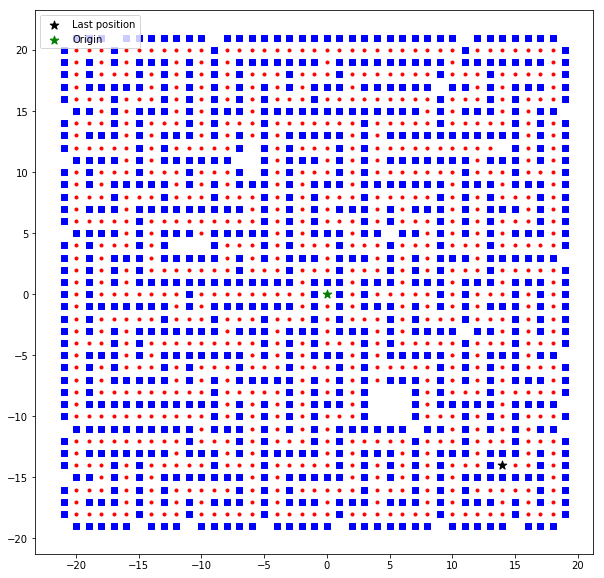

In [6]:
# To find the oxygen module we run the droid inside the room until an output 2 is reached.
# As we know, our function will output True corresponding to output 2 and False otherwise.
ox_tank_found = False
while ox_tank_found is False: 
    ox_tank_found = droid.check_and_move()

print('Oxygen tank found at position: (', droid.track_record[-1].real, droid.track_record[-1].imag, ')')
print('Number of visited positions:', len(set(droid.track_record)))
# The actual distance is given by the length of the instruction sequence (minus 1, since in our implementation
# the initial instruction is None).
print('Length of the instruction sequence:', len(droid.instruc_sequence)-1)

droid.show_map()

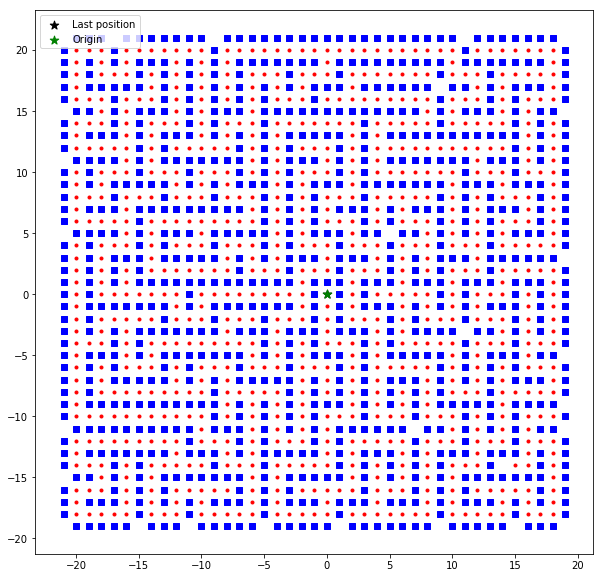

In [7]:
# As we can see, the map is almost fully covered by the robot, except for some spots.
# To proceed to part 2 we must have a complete knowledge of the whole oxygen system, 
# and so we run again the robot (which is now at the oxygen tank). Having reached a dead end (see the map)
# the robot will start a 'backtrack' operation, which will lead him exactly to all those spots which it
# didn't previously visit. We will know that the robot has visited all the possible roads when the
# backtrack operation has led it back to the starting position (0, 0). 
#
while droid.track_record[-1] != 0:
    droid.check_and_move()
    
droid.show_map()

### Part 2

In [19]:
# At this point, the 'map' variable of the robot already contains all information necessary to
# solve part 2, together with the position of the oxygen tank, known to be (14, -14) in our case.
tank = 14-14j

# Calculate total area that the oxygen must cover
area = 1 # including the position of the tank
for position in droid.map:
    if droid.map[position] == 'free':
        area += 1

# Set of all positions filled with oxygen
filled = {tank}
# New positions reached by oxygen
new_pos = [tank]
# Timer
time = 0

# While the positions filled with oxygen do not cover the whole area
while len(filled) != area:
    
    time += 1
    
    # Find the adjacent positions to the ones filled in the previous timestep
    adjacent = set()
    for x in new_pos:
        # Look at all 4 adjacent positions
        for i in droid.instructions[:4]:
            y = x+droid.to_movement[i]
            # If position is free and not already filled, add to adjacent positions
            if droid.map[y] == 'free' and y not in filled:
                adjacent.add(y)
     
    # Fill the adjacent positions with oxygen
    filled.update(adjacent)  
    
    # Update the newly added position set
    new_pos = set(adjacent)

print('Total time of', time, 'minutes to fill an area of', area)

Total time of 406 minutes to fill an area of 799


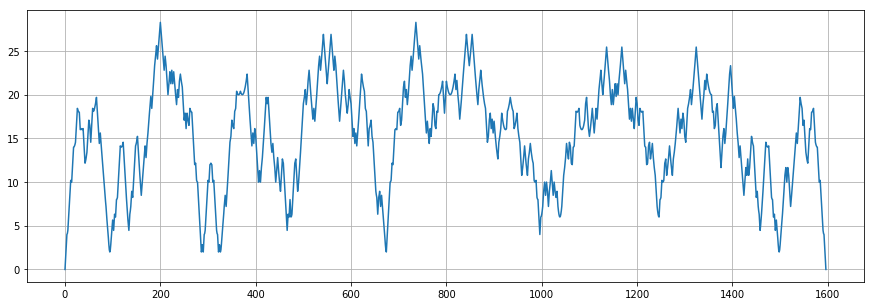

In [17]:
# Plotting the distance of the robot from the origin at every timestep. This was mainly 
# done for debugging purposes, if the distance touched 0 at more than 2 points in the path (the
# robot coming back to the origin mid-exploration) it was an indicator of an error.
plt.figure(figsize=(15, 5))
dist = [abs(x) for x in droid.track_record]
step = [i for i in range(len(dist))]
plt.plot(step, dist)
plt.grid()
plt.show()